Based on 
Dhara, A and M.K. Sen, 2022, Physics-guided deep autoencoder to overcome the need
for a starting model in full-waveform inversion, The Leading Edge.

[https://doi.org/10.1190/tle41060375.1](https://doi.org/10.1190/tle41060375.1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -r /content/drive/MyDrive/Colab\ Notebooks/pinn_fwi/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# !ipython /content/drive/MyDrive/Colab\ Notebooks/pinn_fwi/d_obs_deepwave.py

[TerminalIPythonApp] WARNING | GUI event loop or pylab initialization failed
]0;IPython: /content
UnknownBackendTraceback (most recent call last)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py in enable_matplotlib(self, gui)
   3417         # Now we must activate the gui pylab wants to use, and fix %run to take
   3418         # plot updates into account
-> 3419         self.enable_gui(gui)
   3420         self.magics_manager.registry['ExecutionMagics'].default_runner = \
   3421             pt.mpl_runner(self.safe_execfile)

/usr/local/lib/python3.7/dist-packages/IPython/terminal/interactiveshell.py in enable_gui(self, gui)
    524         if gui:
    525             self.active_eventloop, self._inputhook =\
--> 526                 get_inputhook_name_and_func(gui)
    527         else:
    528             self.active_eventloop = self._inputhook = None

/usr/local/lib/python3.7/dist-packages/IPython/terminal/pt_inputhooks/__init__.py in get_inputhook_name_and

In [4]:
import sys 
sys.path.append("/content/drive/MyDrive/Colab Notebooks/pinn_fwi/")


In [5]:
# sys.path.pop()

In [6]:
# sys.path

In [7]:
from config import *
from networks import Autoencoder

======= Package deepwave is used =========


In [8]:
d_obs = torch.load(
    f= PATH + "/data_model/taux_obs_" + PACKAGE + "_" + MODEL + "_" + str(N_SHOTS)
    )
# d_obs = data_normalization(d_obs)
d_obs = d_obs.unsqueeze(0).to(device=DEVICE)

print(d_obs.shape)

torch.Size([1, 60, 150, 447])


In [9]:
criteria = torch.nn.MSELoss(reduction='sum')

autoencoder = Autoencoder(batch_size=BATCH_SIZE, in_channels=N_SHOTS,
                  n_blocks_encoder=N_BLOCKS_ENCODER, n_blocks_decoder=N_BLOCKS_DECODER,
                  final_size_encoder=FINAL_SIZE_ENCODER, initial_shape_decoder=DECODER_INITIAL_SHAPE,
                  nt=NT, nr=N_RECEIVERS, final_spatial_shape=model_shape,
                  m_min=VP_MIN, m_max=VP_MAX,
                  final_out_channels=1
                  )
autoencoder = autoencoder.to(device=DEVICE)



In [10]:
optim_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, betas=(0.5, 0.9))
scheduler_autoencoder = torch.optim.lr_scheduler.StepLR(optim_autoencoder, 300, gamma=0.5)
all_loss = []
    

In [11]:
for iter in range(ITERATION):
    loss, m , autoencoder = train_fun(Physics=Physics, autoencoder=autoencoder,
                     d_obs=d_obs,
                     optim_autoencoder=optim_autoencoder, criteria=criteria,
                     mini_batches = MINI_BATCHES,
                     src_loc=src_loc, rec_loc=rec_loc, src=src,
                     inpa=inpa, test=None)
    
    all_loss.append(loss)
        
    if iter%50 == 0:
        print(f"Iteration {iter + 1} ===== loss: {all_loss[-1]}")
    if iter%500 == 0:
      plt.figure()
      plt.imshow(m.cpu().detach(), cmap="jet")
      plt.colorbar()
    scheduler_autoencoder.step()



Iteration 1 ===== loss: 96531.11197916667


Iteration 51 ===== loss: 7295.581705729167


Iteration 101 ===== loss: 5256.2998046875


Iteration 151 ===== loss: 2025.08349609375


Iteration 201 ===== loss: 1130.4641520182292


Iteration 251 ===== loss: 1024.9957071940105


Iteration 301 ===== loss: 901.8338419596354


Iteration 351 ===== loss: 861.4320068359375


Iteration 401 ===== loss: 770.5138956705729


Iteration 451 ===== loss: 572.7888997395834


Iteration 501 ===== loss: 542.7106119791666


Iteration 551 ===== loss: 494.77117919921875


Iteration 601 ===== loss: 472.25770060221356


Iteration 651 ===== loss: 425.79799397786456


Iteration 701 ===== loss: 419.05051676432294


Iteration 751 ===== loss: 391.4056803385417


Iteration 801 ===== loss: 382.0633239746094


Iteration 851 ===== loss: 365.06744384765625


Iteration 901 ===== loss: 353.45494588216144


Iteration 951 ===== loss: 338.5731506347656


Iteration 1001 ===== loss: 328.15643310546875


Iteration 1051 ===== loss: 320.4352111816406


Iteration 1101 ===== loss: 313.0259195963542


Iteration 1151 ===== loss: 302.39869181315106


Iteration 1201 ===== loss: 295.23126220703125


Iteration 1251 ===== loss: 290.3072102864583


Iteration 1301 ===== loss: 285.54449462890625


Iteration 1351 ===== loss: 280.9917805989583


Iteration 1401 ===== loss: 276.2349344889323


Iteration 1451 ===== loss: 273.32680257161456


Iteration 1501 ===== loss: 270.4193929036458


Iteration 1551 ===== loss: 267.69521077473956


Iteration 1601 ===== loss: 265.0843200683594


Iteration 1651 ===== loss: 263.3668212890625


Iteration 1701 ===== loss: 261.7811787923177


Iteration 1751 ===== loss: 260.26898193359375


Iteration 1801 ===== loss: 258.7314453125


Iteration 1851 ===== loss: 257.80605061848956


Iteration 1901 ===== loss: 256.9197998046875


Iteration 1951 ===== loss: 256.05504353841144


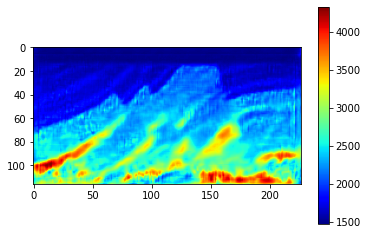

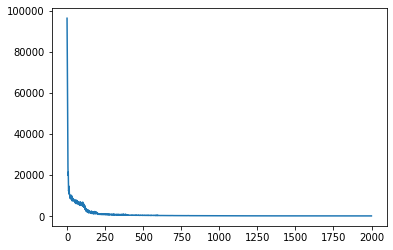

In [12]:
vp, _ = earth_model("marmousi_bl", smooth=15, device="cpu")

fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(121)
ax.imshow(vp, cmap="jet")
ax.set_title("True model")

ax = fig.add_subplot(122)
ax.imshow(m.cpu().detach(), cmap="jet")
ax.set_title("Estimated model")
plt.colorbar()

plt.figure()
plt.plot(all_loss)
plt.grid()


In [25]:
file_name = PATH + "/results2/"+ PACKAGE + "_autoencoder.pth.tar"
save_checkpoint(autoencoder, inpa, file_name)